In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np
from datetime import datetime


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns


import missingno as msno
seed = 555

In [2]:
train_data_path = join('./data', 'train.csv')
test_data_path = join('./data', 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)

### EDA
- 시각화를 통해 Normalize가 필요한 column들을 찾아 전처리를 진행함.
- Normalize할 column들의 특징은 Data가 한쪽으로 치우쳐져 있을 경우(분포 혹은 크기)

In [3]:
# train Data에서 'price'가 label이라 학습을 위해 분리
y = data['price']
data = data.drop(labels='price', axis=1)
data.shape

(15035, 20)

In [4]:
# Train Data에 적용했던 결과를 제출(submission)에도 적용하기 위해 axis=0으로 concatenation을 진행함.
train_len = len(data)
# data = pd.concat((data, sub), axis=0)

In [5]:
# 문자열을 datetime 객체로 변환후 2000년을 기준으로 시간으로 변환
data['date'] = pd.to_datetime(data['date'], format='%Y%m%dT%H%M%S') - datetime(2000, 1, 1)
data['date'] = data['date'].dt.total_seconds() / 3600

# 'id' 컬럼 제거
data = data.drop(labels='id', axis=1)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,129576.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,132816.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,132648.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,126984.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,131832.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

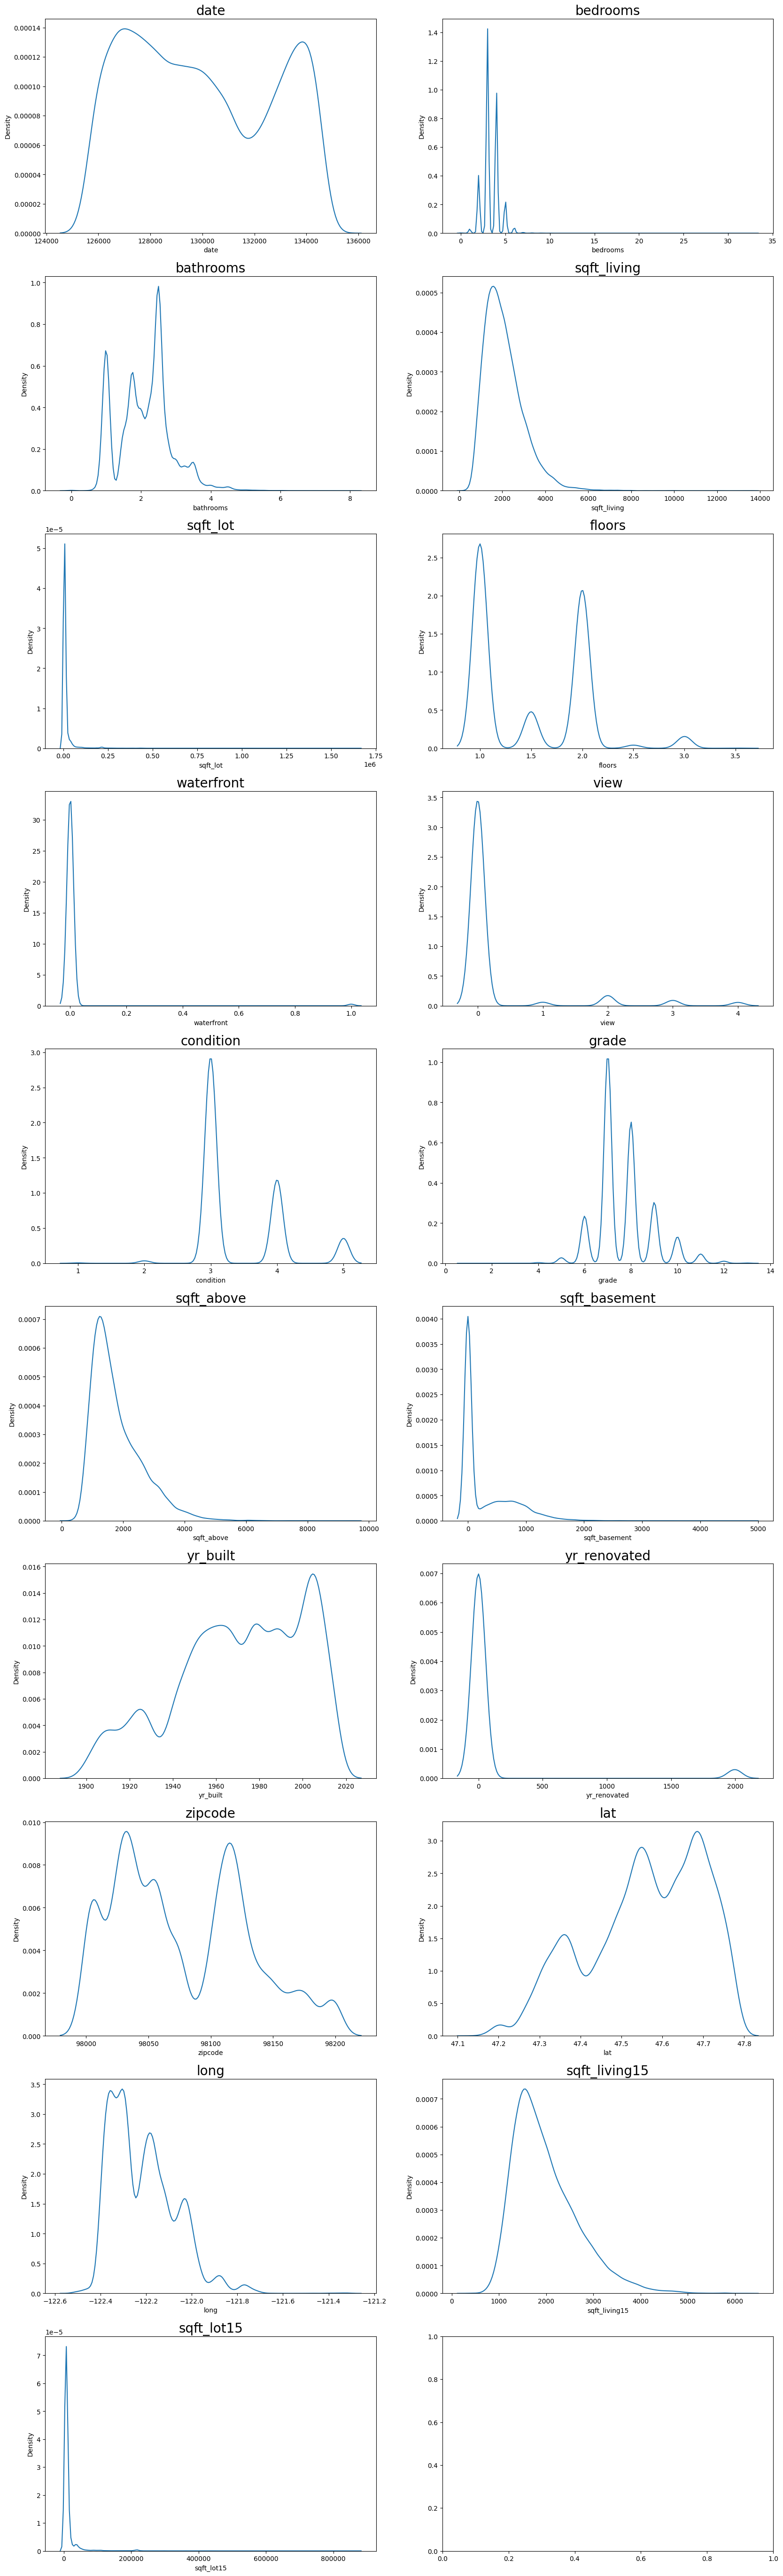

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(20, 70))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=20)
        count+=1
        if count == 19:
            break

### price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement  - log-scaling 전처리

다음 변수들이 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [7]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view','sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

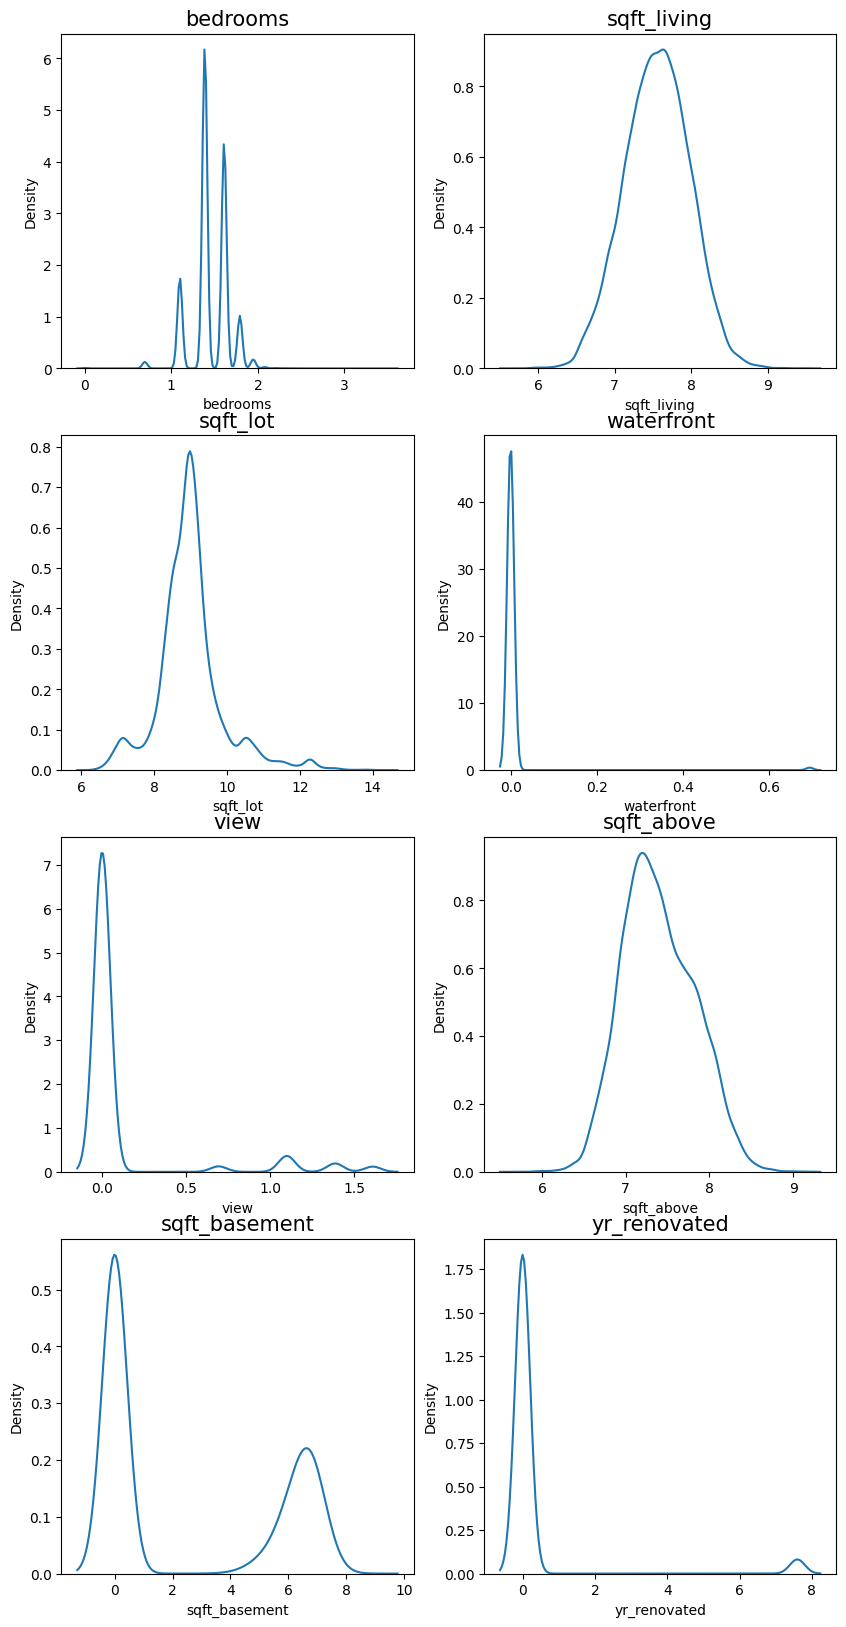

In [8]:
fig, ax = plt.subplots(len(skew_columns)//2, 2, figsize=(10, 20))

count = 0
for row in range(len(skew_columns)//2):
    for col in range(2):
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



In [9]:
# min-max scaleing, 크기가 너무 크거나 작은 것들은 min-max scaling을 통해 성능 향상을 도모함.
skew_columns = ['date', 'yr_built', 'zipcode', 'lat', 'long']

for c in skew_columns:
    min = np.min(data[c])
    max = np.max(data[c])
    data[c] = (data[c]-min)/(max-min)

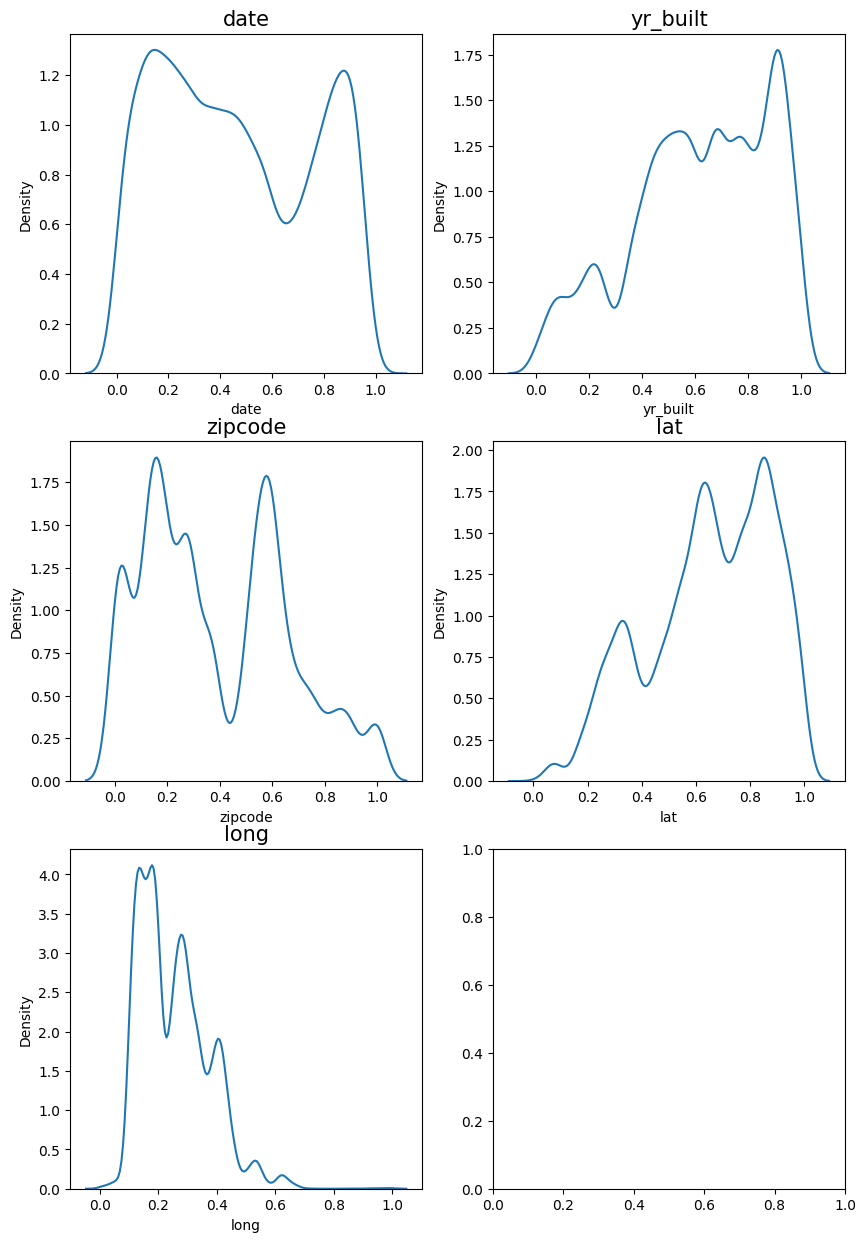

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

### 합쳤던 train set, submission set 분리

In [11]:
submission = np.array(data.iloc[train_len:, :])
train = np.array(data.iloc[:train_len, :])

### target data 로그변환

(15035,)


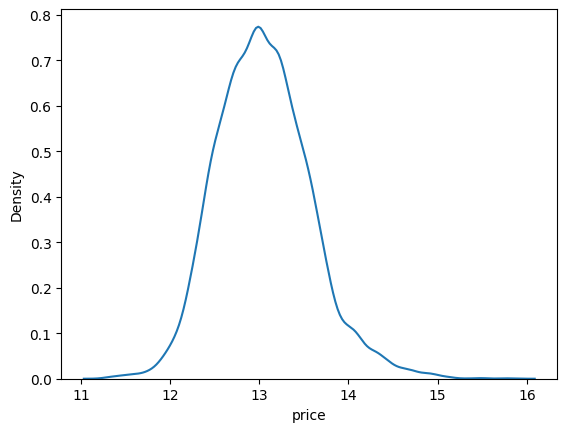

In [12]:
# price가 한쪽으로 치우쳐져있었기 때문에 normalization을 거쳤다
y = np.log1p(y)
sns.kdeplot(data = y)

print(y.shape)

## 모델 후보들과 하이퍼 파라미터 그리드

모델 후보들로는 GradientBoostingRegressor, xgboost, lightgbm 가 있다.

파라미터 그리드:

- n_estimators - 트리의 개수 (기본값: 100)
- max_depth - 트리의 최대 깊이 (기본값: 3)
- learning_rate - 각 트리의 기여도를 조절하는 학습률 (기본값: 0.1)

In [13]:
gboost = GradientBoostingRegressor(random_state=seed)
xgboost = XGBRegressor(random_state=seed)
lightgbm = LGBMRegressor(random_state=seed)

models = [lightgbm, xgboost]

param_grid = {
    'n_estimators': [100, 300, 500, 1000], #n_estimator를 크게 잡는 경우가 많았다
    'max_depth': [3, 5, 10],  # depth를 굳이 깊이 잡는 것 같지 않았다
    'learning_rate': [0.1, 0.01] #learning rate은 0.1로 선택
}


### 다중 모델 gridsearch -> model & parameter selection

In [14]:
def my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5):
    results = pd.DataFrame()
    for model in models:
        model_name = model.__class__.__name__
        grid_model = GridSearchCV(model, param_grid=param_grid, \
                                  scoring='neg_mean_squared_error', \
                                  cv=5, verbose=verbose, n_jobs=n_jobs)
        grid_model.fit(train, y)

        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
        
        tmp = pd.DataFrame(params)
        tmp['score'] = score
        tmp['RMSLE'] = np.sqrt(-1 * score)
        tmp['model'] = model_name
        results = pd.concat([results, tmp])

    results_sorted = results.sort_values(by=['RMSLE'])

    return results_sorted


In [15]:
my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END ...learning_rate=0.

,learning_rate,max_depth,n_estimators,score,RMSLE,model
9,0.10,10,300,-0.026184,0.161815,LGBMRegressor
6,0.10,5,500,-0.026301,0.162176,XGBRegressor
10,0.10,10,500,-0.026314,0.162215,LGBMRegressor
23,0.01,10,1000,-0.026314,0.162216,XGBRegressor
3,0.10,3,1000,-0.026407,0.162502,LGBMRegressor
7,0.10,5,1000,-0.026490,0.162757,XGBRegressor
6,0.10,5,500,-0.026610,0.163126,LGBMRegressor
5,0.10,5,300,-0.026650,0.163249,XGBRegressor
9,0.10,10,300,-0.026701,0.163404,XGBRegressor
23,0.01,10,1000,-0.026711,0.163435,LGBMRegressor


### 상위 K(=6)개 모델 선택

In [18]:
"""
9	0.10	10	300	-0.026184	0.161815	LGBMRegressor
6	0.10	5	500	-0.026301	0.162176	XGBRegressor
10	0.10	10	500	-0.026314	0.162215	LGBMRegressor
23	0.01	10	1000	-0.026314	0.162216	XGBRegressor
3	0.10	3	1000	-0.026407	0.162502	LGBMRegressor
7	0.10	5	1000	-0.026490	0.162757	XGBRegressor
"""
ensemble_model_list = [
    LGBMRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 300, random_state=seed),
    XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 500, random_state=seed),
    LGBMRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 500, random_state=seed),
    XGBRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 10000, random_state=seed),
    LGBMRegressor(learning_rate = 0.1, max_depth = 3, n_estimators = 1000, random_state=seed),
    XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 10000, random_state=seed)
]
# VotingRegressor를 사용하여 모델들을 앙상블
ensemble_model = VotingRegressor(estimators=[f'model_{i}' for i, model in enumerate(ensemble_model_list)])

# 앙상블 모델 훈련
ensemble_model.fit(train, y)

# 앙상블 모델로 예측
prediction = ensemble_model.predict(submission)
prediction = np.expm1(prediction)


ValueError: too many values to unpack (expected 2)

In [ ]:
data_dir = './data'

submission_path = join(data_dir, 'sample_submission.csv')
submission_ = pd.read_csv(submission_path)
submission_['price'] = prediction

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir,'0.161815')
submission_.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./data/submission_2lgbm+2xgbr_RMSLE_0.161815.csv


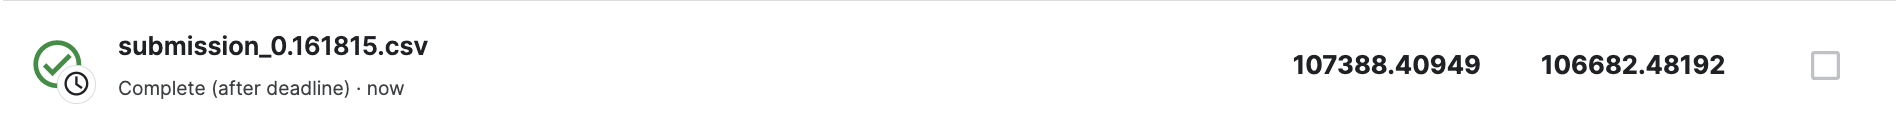